# AIoT Project 2023

In [2]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
# import seaborn as sns

# db
import pymongo

# configs & other
import yaml
# from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

# from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%load_ext autoreload
%autoreload 2

Start time of execution

In [3]:
time_start = time()

## Load configuration

In [4]:
config_path = "config.yml"

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
client = pymongo.MongoClient(config["client"])

In [6]:
db = client[config["db"]]
coll = db[config["col"]]

In [7]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['α', 'β', 'γ', 'δ']


In [8]:
data = list(coll.find({}, {'label': 1, 'data': 1, 'datetime': 1}))
df = pd.DataFrame(data)
print(df.iloc[0])
print(df.shape)

_id                                  6474fbf927fabee5f206a8d4
data        {'acc_x': [0.136, 0.13, 0.121, 0.135, 0.145, 0...
label                                                       α
datetime                              2023-05-17 20:44:55.691
Name: 0, dtype: object
(80, 4)


## Barplot (Mean Length of data per Label)

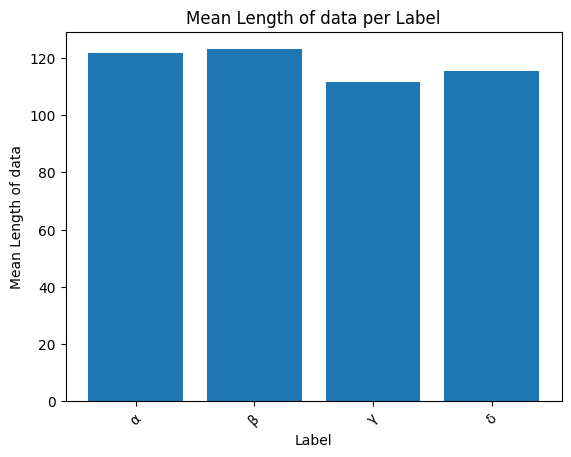

In [9]:
# distinct labels
labels = df["label"].unique() # type: ignore
# get data length for each label
label_mean_lengths = df.groupby('label')['data'].apply(lambda x: x.apply(lambda arr: len(arr['acc_x'])).mean())

# Create a bar plot
plt.bar(label_mean_lengths.index, label_mean_lengths.values) # type: ignore

# Set labels and title
plt.xlabel('Label')
plt.ylabel("Mean Length of data")
plt.title("Mean Length of data per Label")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Windows

In [10]:
sl  = config["sliding_window"]
w = []

for x in df["data"]:
    df_x = pd.DataFrame(x) # type: ignore
    windows = sliding_window_pd(df_x, ws= sl["ws"], overlap= sl["overlap"], w_type= sl["w_type"], w_center= sl["w_center"], print_stats= sl["print_stats"])
    w.append(pd.Series(windows))

df["windows"] = w

30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 ha

## Barlpot of the number of windows per label

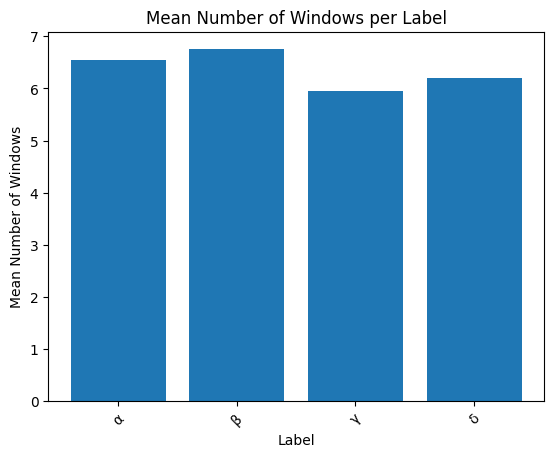

In [11]:
# distinct labels
labels = df["label"].unique() # type: ignore
# get data length for each label
windows_mean_lengths = df.groupby('label')['windows'].apply(lambda x: x.apply(lambda arr: len(arr)).mean())

# Create a bar plot
plt.bar(windows_mean_lengths.index, windows_mean_lengths.values) # type: ignore

# Set labels and title
plt.xlabel('Label')
plt.ylabel("Mean Number of Windows")
plt.title("Mean Number of Windows per Label")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Apply filter

In [12]:
# Apply a low filter to the data
df_filtered = df.copy()

for i,x in enumerate(df["windows"]):
    for j,y in enumerate(x): # type: ignore
        for k in y:
            df_filtered["windows"][i][j][k] = apply_filter(y[k])

In [13]:
# get list from df["windows"]
windows = df["windows"].tolist() # type: ignore
# ilter_instances(instances_list, order, wn, filter_type)
filtered_windows = filter_instances(windows, order= config["filter"]["order"], wn= config["filter"]["wn"], filter_type= config["filter"]["type"])
# print("windows:", type(windows), len(windows))

Number of filtered instances in the list: 80


## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [14]:
# np_filtered_windows = []

# for x in filtered_windows:
#     np_filtered_windows.append(np.array(x))

# print(len(np_filtered_windows))
# np_filtered_windows = np.array(np_filtered_windows)
# print(np_filtered_windows[0][0].shape)
new_df = flatten_instances_df(filtered_windows)
# print(new_df[0][0])

## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [15]:
X = np.array(new_df)

length = []

for i,x in enumerate(X):
    none_count = 0
    for j,y in enumerate(x):
        if y is None:
            none_count += 1
    length.append(len(x) - none_count)
median_length = np.median(length)

to_remove = []
# Keep where length is less than median length
for i,x in enumerate(length):
    if x < median_length:
        to_remove.append(i)

# make X keep from 1 to median length
X = X[:, :int(median_length)]
print(median_length)
# X = X[:, :int(median_length)]

X = np.delete(X, to_remove, axis=0)

print(X.shape)

X = np.array([np.array([x.flatten() for x in row]) for row in X])
print(X.shape)


# print(X[0])

# print(X[0][0].shape)
# flattened_X = np.concatenate([x.flatten() for x in X], axis=0).reshape(2, -1)
# Flatten every instance inside X array
# flattened_X = np.array([np.array([x.flatten() for x in row]) for row in X])
# flattened_X = np.array([x.flatten() for row in X for x in row if x is not None])
# flattened_X = np.array([x.flatten() for row in X for x in row if x is not None])
# print(flattened_X[0].shape)
# print(X[0][0].flatten().shape)
# print(X.shape)
y = np.array(df["label"].tolist()) # type: ignore
y = np.delete(y, to_remove, axis = 0)
# turn labels into numbers
y = pd.factorize(y)[0]
print(y.shape)
# print(flattened_X[0][0].shape)

6.0
(75, 6)
(75, 6, 180)
(75,)


## Train/Test split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

In [18]:
print(X_train.shape)
print(y_train)
print(median_length)

(60, 6, 180)
[1 0 1 3 3 2 2 0 2 2 1 0 3 2 1 2 2 1 3 1 3 0 2 0 0 1 0 3 0 1 3 3 2 3 0 1 2
 1 2 1 2 3 3 0 1 3 3 3 1 1 0 2 1 0 1 1 3 3 0 2]
6.0


## Scaling

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [20]:
# Standard scaler for X
scaler = StandardScaler()

# MinMax scaler for X
scaler2 = MinMaxScaler()

# Reshape data to 2d array
train_data_scaled = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
test_data_scaled = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

# Fit on training set only.
scaler2.fit(train_data_scaled)

# Apply transform to both the training set and the test set.
train_data_scaled = scaler2.transform(train_data_scaled)
test_data_scaled = scaler2.transform(test_data_scaled)

# Fit on training set only.
scaler.fit(train_data_scaled)

# Apply transform to both the training set and the test set.
train_data_scaled = scaler.transform(train_data_scaled)
test_data_scaled = scaler.transform(test_data_scaled)


# print(train_data_scaled.shape)
# print(test_data_scaled.shape)

## Transform to 2D again

In [21]:
X_train_2d = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_2d = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [22]:
# add transformers
from sklearn.decomposition import PCA

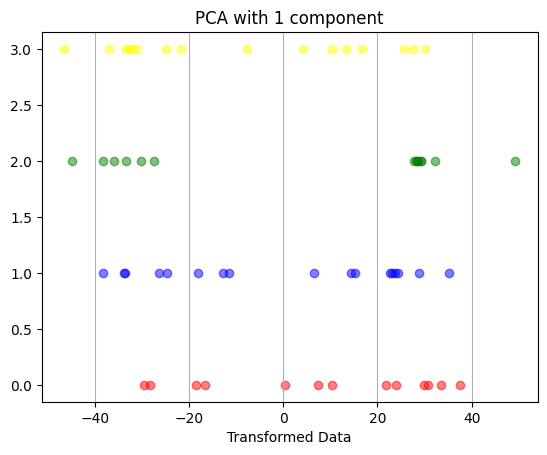

[[ 23.75040659]
 [ 21.79183709]
 [-11.56566325]
 [ 13.36393085]
 [-37.01282175]
 [ 29.23032067]
 [ 49.2611854 ]
 [-28.32617679]
 [ 28.63287516]
 [ 28.13965381]
 [-18.00876895]
 [ 30.74842652]
 [ 27.46503325]
 [ 27.83026664]
 [-26.34057516]
 [-35.96303855]
 [-27.52257599]
 [ 28.74632328]
 [  4.12115788]
 [  6.48191614]
 [ -7.65901201]
 [  0.43275445]
 [-38.30329731]
 [ 37.45531246]
 [-29.5973732 ]
 [-33.65130957]
 [ 29.94131112]
 [-32.06025161]
 [ 23.9270288 ]
 [-38.30304682]
 [-32.82178342]
 [ 25.6375568 ]
 [ 28.37992952]
 [-46.52016722]
 [-16.54164294]
 [ 22.63862285]
 [ 32.24276728]
 [ 23.04547112]
 [-30.2751896 ]
 [ 14.35822266]
 [ 29.1919174 ]
 [-24.9956602 ]
 [ 16.61919265]
 [-18.57728562]
 [-33.80477129]
 [-31.12393037]
 [ 10.24734656]
 [-21.69904095]
 [-24.75447516]
 [-12.81133669]
 [ 33.55337703]
 [-33.43105454]
 [ 35.27084672]
 [  7.44164105]
 [ 15.276429  ]
 [ 24.46987879]
 [ 30.07135168]
 [-33.54743176]
 [ 10.40788159]
 [-44.95449208]]


In [23]:
# PCA with 1 component
pca = PCA(n_components=1)

# Transform data and plot
fig, ax = plt.subplots()
transformed_data = []

transformed_x = pca.fit_transform(train_data_scaled)

colors = {0: "red", 1: "blue", 2: "green", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "black", 9: "gray"}

for i,x in enumerate(transformed_x):
    ax.scatter(x, y_train[i], alpha=0.5, label="PCA", color=colors[y_train[i]])
ax.set_xlabel("Transformed Data")
ax.set_title("PCA with 1 component")
ax.xaxis.grid(True)
plt.show()

print(transformed_x)

### PCA with 2 Components

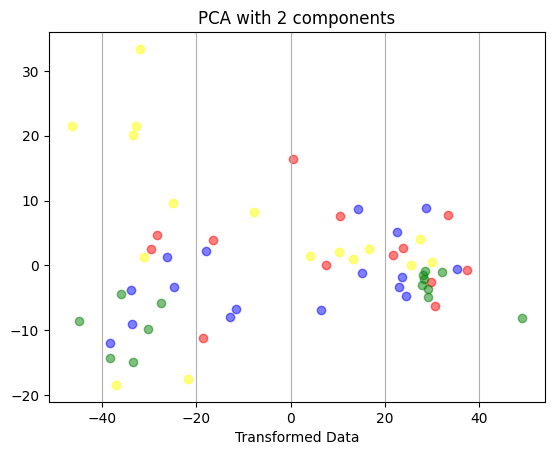

In [24]:
pca = PCA(n_components=2)
transformed_x = pca.fit_transform(train_data_scaled)

fig, ax = plt.subplots()
for i,x in enumerate(transformed_x):
    ax.scatter(x[0], x[1], alpha=0.5, label="PCA", color=colors[y_train[i]])
ax.set_xlabel("Transformed Data")
ax.set_title("PCA with 2 components")
ax.xaxis.grid(True)
plt.show()

In [25]:
# pca_explained_variance_bar(pca_object, alpha=0.8)


In [26]:
# plot_heatmap(df=DATAFRAME)

### PCA with 3 Components

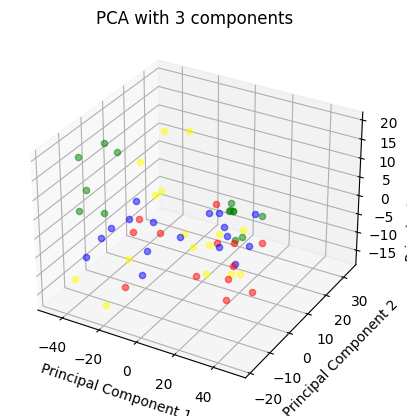

In [27]:
pca = PCA(n_components=3)
transformed_x = pca.fit_transform(train_data_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,x in enumerate(transformed_x):
    ax.scatter(x[0], x[1], x[2], alpha=0.5, label="PCA", color=colors[y_train[i]])
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA with 3 components")
ax.xaxis.grid(True)
plt.show()

### PCA with X% of the variance of the dataset, for training the statistical AI Models

In [28]:
# pca with x% variance
pca = PCA(0.98)
X_train = pca.fit_transform(train_data_scaled)
X_test = pca.transform(test_data_scaled)

## Classifier - Statistical Learning

### Apply simple classifier

In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [30]:
svm = SVC(kernel="linear", C=1, random_state=42)
svm.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate simple classifier

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
from sklearn.metrics import classification_report

Accuracy:  0.8
Accuracy:  0.6666666666666666
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         2
           3       0.60      0.75      0.67         4

    accuracy                           0.80        15
   macro avg       0.86      0.81      0.82        15
weighted avg       0.83      0.80      0.80        15



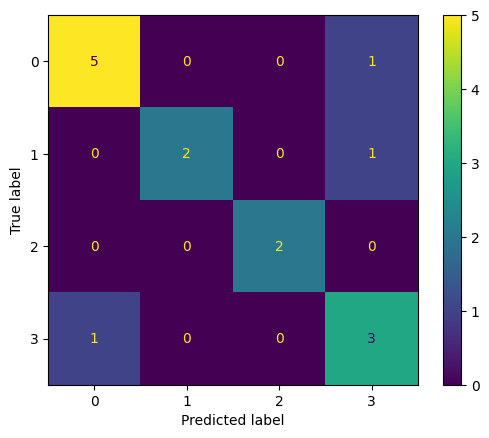

In [33]:
accuracy = svm.score(X_test, y_test)
print("Accuracy: ", accuracy)

accuracy = rf.score(X_test, y_test)
print("Accuracy: ", accuracy)

print(classification_report(y_test, svm.predict(X_test)))

# confusion matrix
cm = confusion_matrix(y_test, svm.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()


### Apply optimization with Grid Search and Cross-validation

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [35]:
# Apply grid search to find best parameters for SVM
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

### Evaluate optimized classifier

In [36]:
# evaluate the model
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

# Evaluate the model on the test data using `score`
y_pred = grid.predict(X_test)
accuracy = grid.score(X_test, y_test)
print("Accuracy: ", accuracy)

Best parameters:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best estimator:  SVC(C=10, gamma=0.001)
Best score:  0.7499999999999999
Accuracy:  0.8


## Classifier - Neural Network

In [37]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [38]:
input_data_shape = X_train_2d[0].shape
print("Type of the input shape object:", type(input_data_shape))
X_train_2d[0].shape

Type of the input shape object: <class 'tuple'>


(6, 180)

In [39]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

Number of outputs (classes) the model to predict: 4


### Create the Neural Network (NN) Architecture and instantiate the model

In [40]:
model = Sequential()
model.add(Dense(30, activation="relu", input_shape=input_data_shape))
model.add(Dense(n_outputs, activation="softmax"))

Plot the Architecture of ot the TensorFlow model

In [44]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Plot the summary of the TensorFlow model

In [45]:
# plot the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 30)             5430      
                                                                 
 dense_1 (Dense)             (None, 6, 4)              124       
                                                                 
Total params: 5,554
Trainable params: 5,554
Non-trainable params: 0
_________________________________________________________________


### Build the NN model

In [46]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy, sparse_categorical_crossentropy,loss"])

In [47]:
# from utils import encode_labels

##### Split the data into training, testing, and validation sets

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [50]:
from sklearn.preprocessing import OneHotEncoder
# encode labels with one hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
print("Shape of the encoded labels:", y_train.shape)
print(y_train)

Shape of the encoded labels: (192, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]

### Train the NN model

In [51]:
# Train the model and validate it with the validation set
print(X_train.shape, y_train.shape)
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

ValueError: Data cardinality is ambiguous:
  x sizes: 48
  y sizes: 192
Make sure all arrays contain the same number of samples.

### Evaluate the model on the test data

In [ ]:
# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets